## Imports and data loading

In [29]:
from joblib import dump, load

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import pickle
import xgboost as xgb
print(f'Pickle Version: {pickle.format_version}')

Pickle Version: 4.0


In [4]:
_pth_tst = '../data/test_2022-08-08.csv'
_pth_trn = '../data/train_2021-12-24.csv'
_pth_emb = '../data/embeddings.pkl'
_pth_enc ='../data/encoders.pkl'

train = pd.read_csv(_pth_trn)
test = pd.read_csv(_pth_tst)

with open(_pth_emb, 'rb') as handle:
    embeds = pickle.load(handle)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99144 entries, 0 to 99143
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sale_Price          99144 non-null  float64
 1   Odometer            99119 non-null  float64
 2   Power               99090 non-null  float64
 3   Fuel_Urban          87810 non-null  float64
 4   Make_Code           99144 non-null  object 
 5   Family_Code         99144 non-null  object 
 6   Year_Group          99144 non-null  int64  
 7   Region_Description  99144 non-null  object 
 8   Vehicle_Code        99144 non-null  int64  
 9   adv_date            99144 non-null  object 
 10  sld_date            99144 non-null  object 
 11  inventory_days      99144 non-null  int64  
 12  age_list_day        99144 non-null  int64  
 13  age_sell_day        99144 non-null  int64  
 14  sld_wknum           99144 non-null  int64  
 15  adv_wknum           99144 non-null  int64  
 16  km_p

## Retrive Encodings

In [6]:
feat_cols = ['Odometer', 'Power', 'Fuel_Urban', 'inventory_days', 
             'age_sell_day', 'km_per_day', 'fuel_per_power', 
             'odo_per_fuel', 'odo_per_power','pow_times_odo']

enc_cols = list(embeds)
enc_cols

['Make_Code', 'Family_Code', 'Region_Description']

In [9]:
def get_embedded_feat(feat, encod_dict, feat_name='Family_Code'):
    '''Return embeddings from feature column using encoded dict
    '''
    feat_df = feat.to_frame()
    encodings = encod_dict[feat_name].reset_index()
    feat_tranf = feat_df.merge(encodings, how='left', left_on=[feat_name], right_on=['index'], indicator=True)
    # print(feat_tranf._merge.value_counts())
    return feat_tranf.loc[:,[c for c in encodings.columns if c.startswith(feat_name)]]

In [10]:
embed_dflist = []
embed_dflist_test = []


for f in list(embeds):
    df = get_embedded_feat(train[f], embeds, feat_name=f)
    embed_dflist.append(df)
    df_test = get_embedded_feat(test[f], embeds, feat_name=f)
    embed_dflist_test.append(df_test)

In [11]:
X_train_df = pd.concat([train.loc[:,feat_cols]]+embed_dflist, axis=1)
y_train = train.loc[:,'Sale_Price']

X_test_df = pd.concat([test.loc[:,feat_cols]]+embed_dflist_test, axis=1)
y_test = test.loc[:,'Sale_Price']

In [12]:
X_train_df.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
Odometer,99119.0,80119.0,58326.0,0.0,37745.5,70801.0,111000.0,4000380.0
Power,99090.0,140.2,51.5,28.0,110.0,129.0,147.0,545.0
Fuel_Urban,87810.0,10.3,2.8,0.9,8.6,9.9,11.3,26.4
inventory_days,99144.0,35.2,38.2,1.0,14.0,27.0,46.0,2086.0
age_sell_day,99144.0,2189.3,1283.0,58.0,1269.0,1953.0,2879.0,9467.0
km_per_day,99119.0,36.5,20.7,0.0,23.2,34.1,46.6,2132.4
fuel_per_power,87810.0,0.1,0.0,0.0,0.1,0.1,0.1,0.2
odo_per_fuel,87789.0,7482.1,5571.3,0.0,3611.7,6639.8,10290.0,519529.9
odo_per_power,99065.0,636.7,515.7,0.0,270.1,529.9,875.2,28371.5
pow_times_odo,99065.0,11081457.4,8994626.7,0.0,4664149.0,9124050.0,15190890.0,564053580.0


In [13]:
knn = KNNImputer()
X_train = knn.fit_transform(X_train_df)
X_test = knn.transform(X_test_df)

In [30]:
dump(knn, 'knnimputer.joblib')

['knnimputer.joblib']

In [17]:
# load xg model

model = xgb.XGBRegressor()
model.load_model("../xgb_model.json")

## SHAPE explainer

In [19]:
import shap

In [25]:
Xtrain_df = pd.DataFrame(X_train, columns=X_train_df.columns)
Xtest_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [41]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xtest_df)
shap_values_tr = explainer.shap_values(Xtrain_df)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


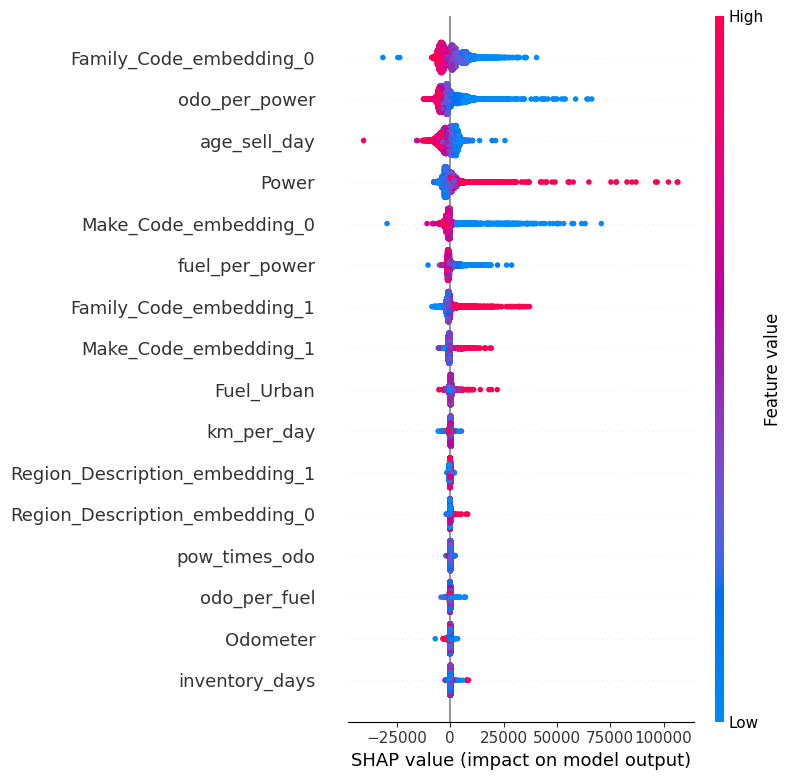

In [42]:
shap.summary_plot(shap_values, Xtest_df)

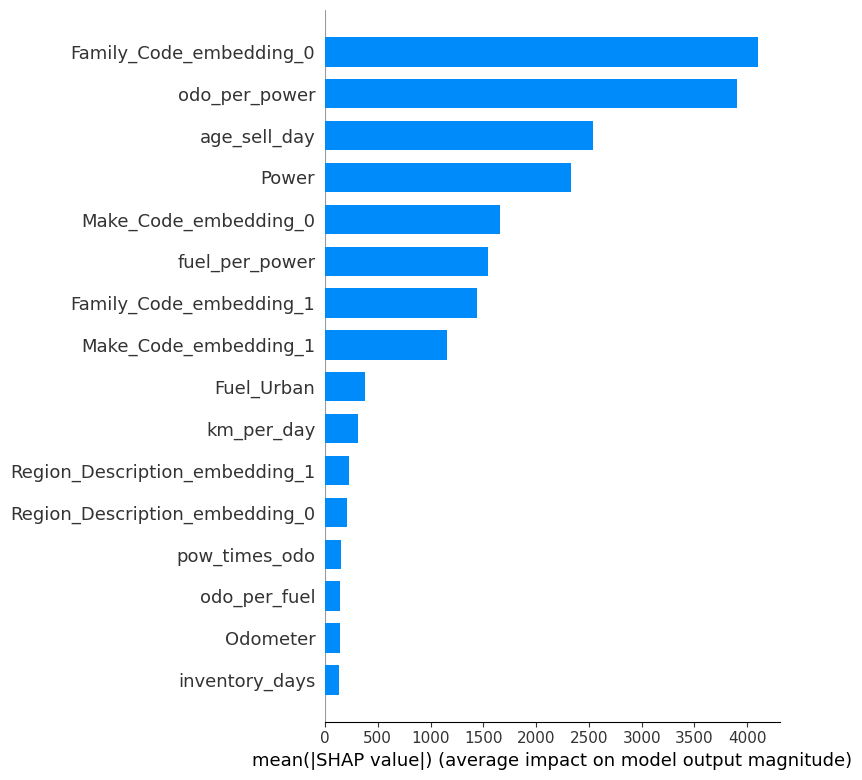

In [44]:
shap.summary_plot(shap_values, Xtest_df, plot_type="bar", show=False)

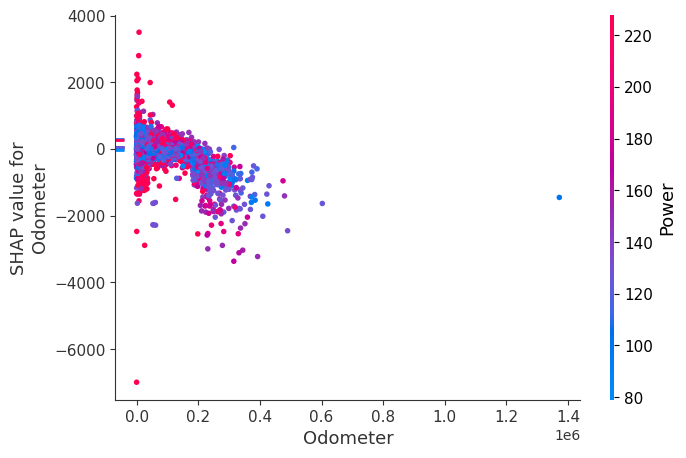

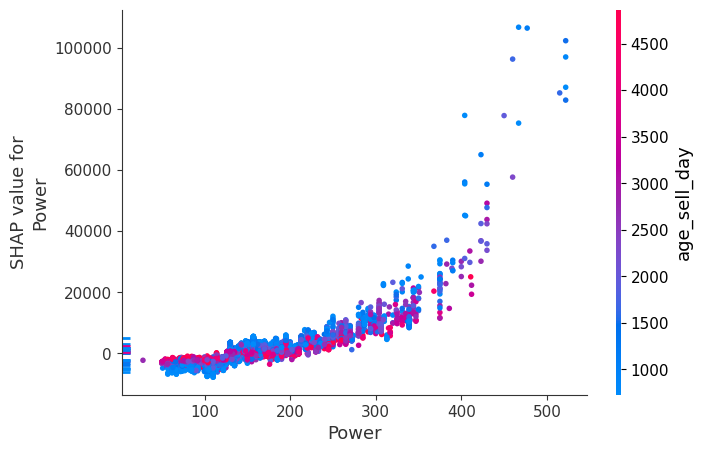

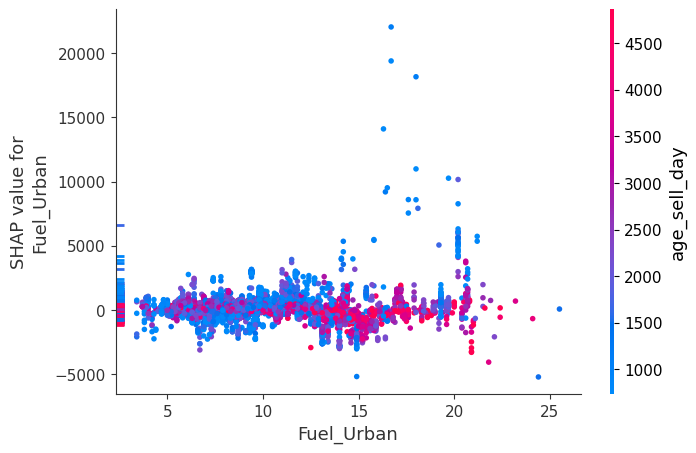

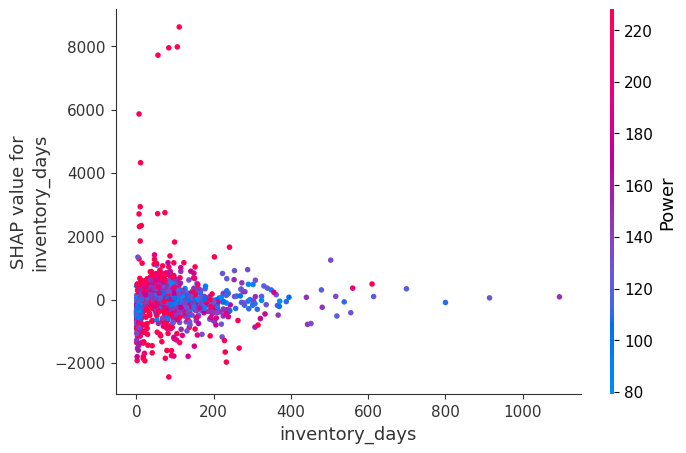

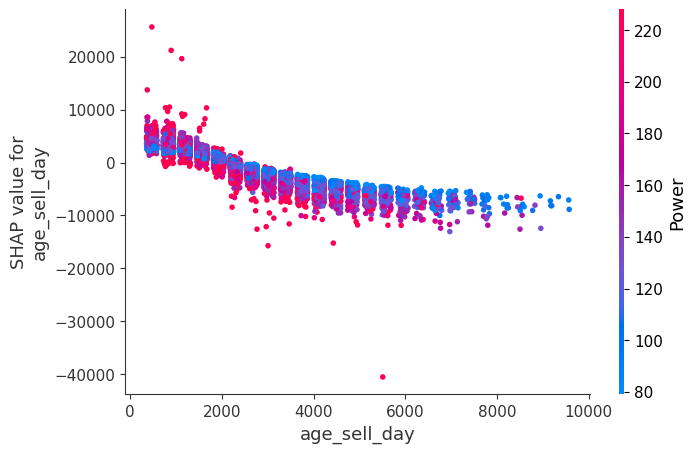

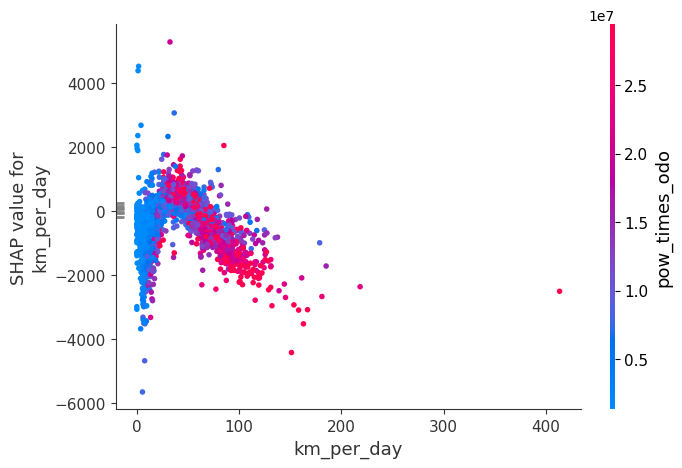

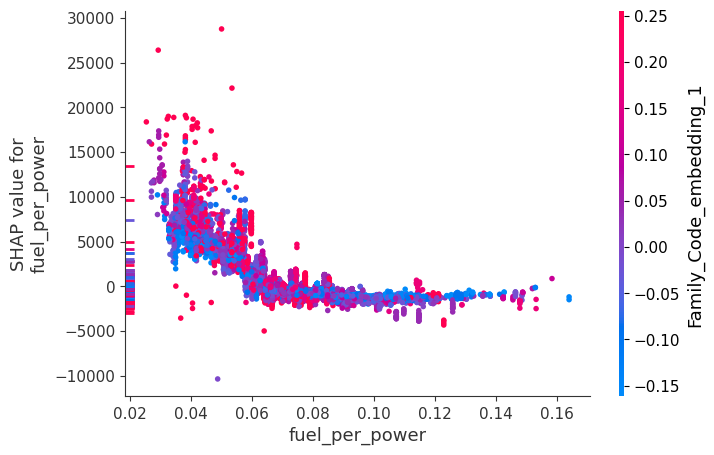

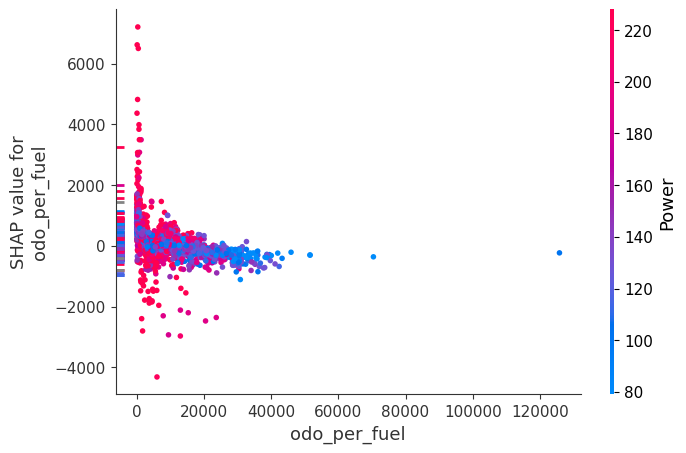

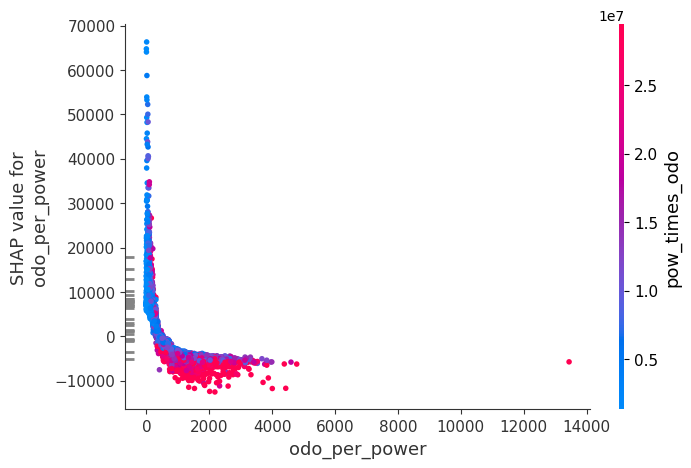

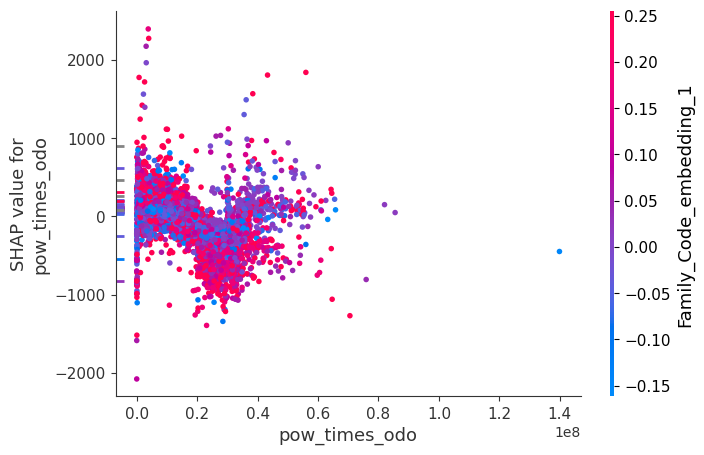

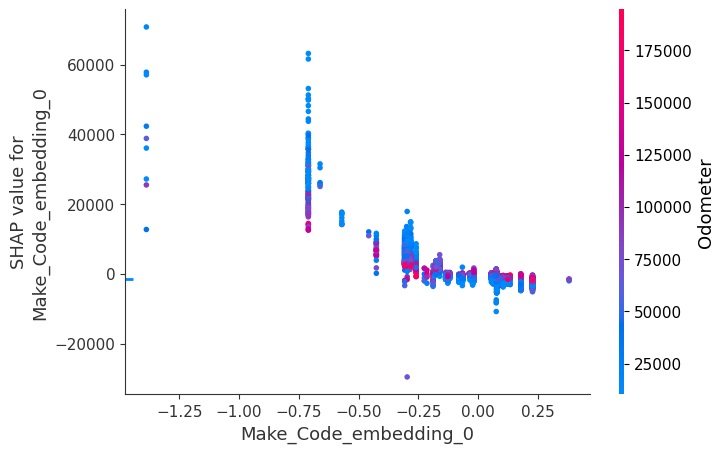

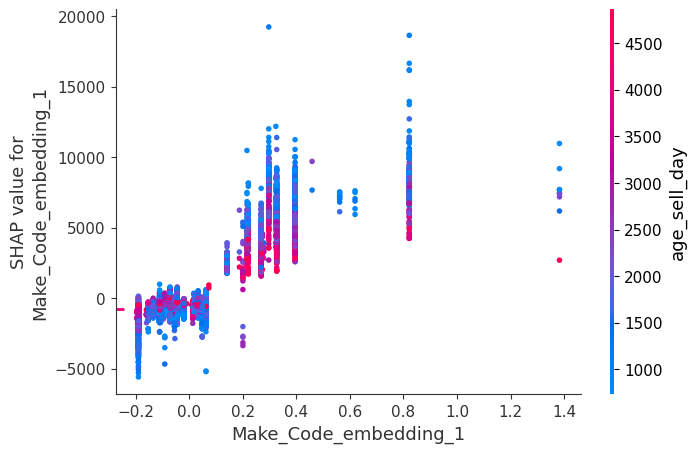

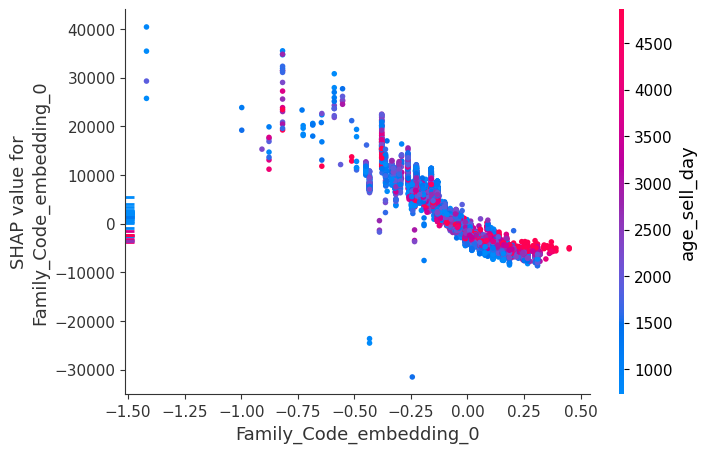

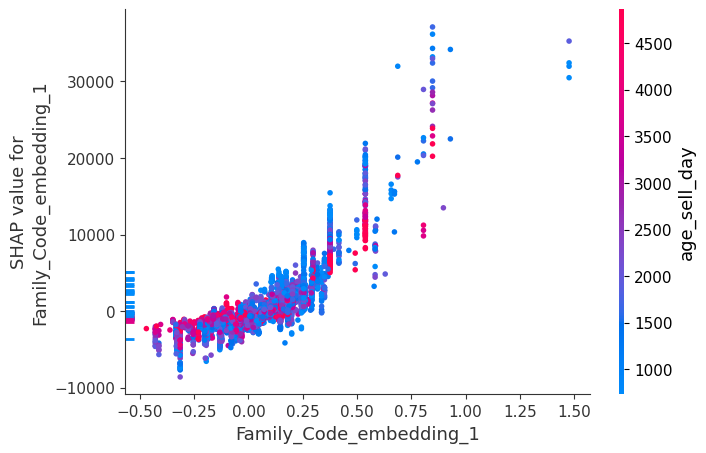

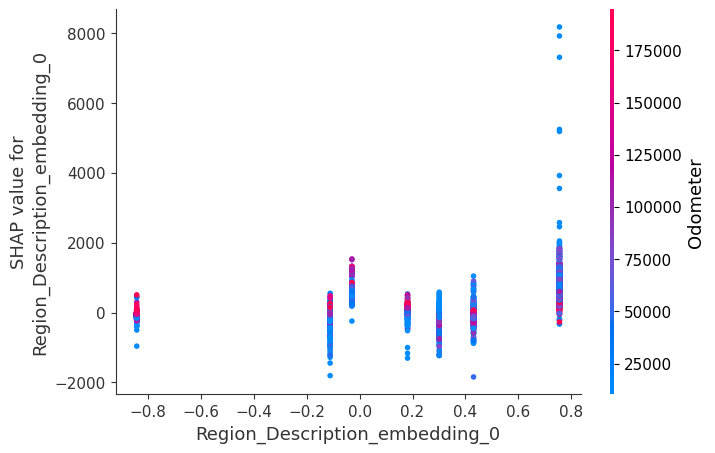

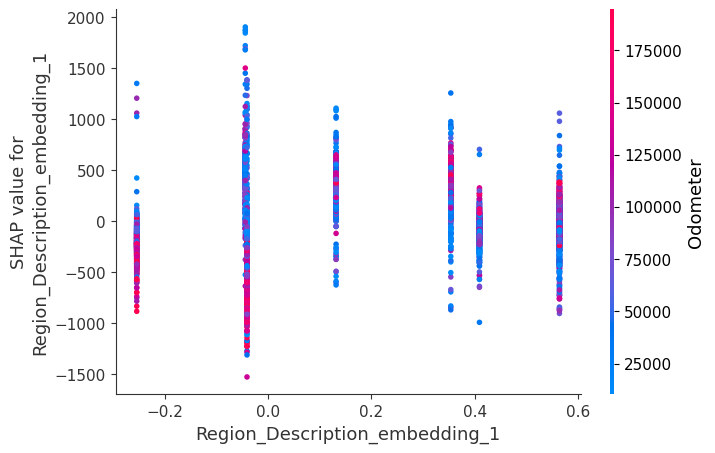

In [51]:
for i in X_test_df.columns:
    shap.dependence_plot(i, shap_values, X_test_df)

In [65]:
n=4
choosen_instance, price = X_test_df.iloc[[n]], y_test.iloc[n]
print(f"Price {price}")
choosen_instance.T

Price 31818.19


,4
Odometer,9.502900e+04
Power,1.800000e+02
Fuel_Urban,8.300000e+00
inventory_days,1.400000e+01
age_sell_day,2.914000e+03
km_per_day,3.261119e+01
fuel_per_power,4.611111e-02
odo_per_fuel,1.144928e+04
odo_per_power,5.279389e+02
pow_times_odo,1.710522e+07


In [64]:
shap_value = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_value, choosen_instance)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
